In [97]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import sagemaker
import boto3

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [3]:
#Create a copy of each dataset
df_portfolio = portfolio.copy()
df_profile = profile.copy()
df_transcript = transcript.copy()

In [4]:
print('Portfolio dimension: ',df_portfolio.shape)
print('Profile dimension: ',df_profile.shape)
print('Transcript dimension: ',df_transcript.shape)

Portfolio dimension:  (10, 6)
Profile dimension:  (17000, 5)
Transcript dimension:  (306534, 4)


In [5]:
df_portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


# Cleaning Data - Portfolio

In [6]:
# Check for missing values
df_portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [7]:
# Get the channel list
channels = df_portfolio.channels.explode().unique()
channels

array(['email', 'mobile', 'social', 'web'], dtype=object)

In [8]:
# Create separate column for each channel
for channel in channels:
    df_portfolio.loc[:, channel] = df_portfolio.loc[:, "channels"].apply(lambda x: channel in x).astype(int)

In [9]:
#Drop the channels column
df_portfolio.drop(columns=['channels'], inplace=True)

In [10]:
df_portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [11]:
#Rename the id column to offer_id
df_portfolio.rename(columns={'id':'offer_id'}, inplace=True)

* As there are 10 offers given for this product and the id's have complex values, let us map the values with numbers

In [12]:
offer_id_list = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 1,
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
    '3f207df678b143eea3cee63160fa8bed': 3,
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
    'fafdcd668e3743c1bb461111dcafc2a4': 7,
    '5a8bc65990b245e5a138643cd4eb9837': 8,
    'f19421c1d4aa40978ebb69ca19b0e20d': 9,
    '2906b810c7d4411798c6938adc9daaa5': 10,
}

df_portfolio.loc[:,'offer_id'] = df_portfolio.loc[:,'offer_id'].map(offer_id_list)

In [13]:
df_portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,1,1,1,1,0
1,10,10,5,bogo,2,1,1,1,1
2,0,0,4,informational,3,1,1,0,1
3,5,5,7,bogo,4,1,1,0,1
4,5,20,10,discount,5,1,0,0,1
5,3,7,7,discount,6,1,1,1,1
6,2,10,10,discount,7,1,1,1,1
7,0,0,3,informational,8,1,1,1,0
8,5,5,5,bogo,9,1,1,1,1
9,2,10,7,discount,10,1,1,0,1


In [14]:
df_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   difficulty  10 non-null     int64 
 2   duration    10 non-null     int64 
 3   offer_type  10 non-null     object
 4   offer_id    10 non-null     int64 
 5   email       10 non-null     int64 
 6   mobile      10 non-null     int64 
 7   social      10 non-null     int64 
 8   web         10 non-null     int64 
dtypes: int64(8), object(1)
memory usage: 848.0+ bytes


## Exploratory Data Analysis - Portfolio

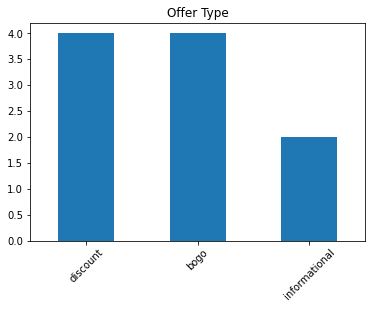

In [15]:
df_portfolio.offer_type.value_counts().plot(kind='bar')
plt.title('Offer Type')
plt.xticks(rotation=45)
plt.show()

This shows most of the offers given are either buy one get one free or discounts.

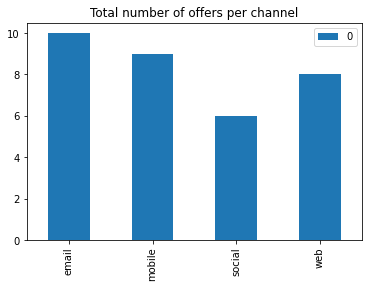

In [16]:
data=df_portfolio[['email','mobile','social','web']].sum().to_frame()
data.plot.bar()
plt.title('Total number of offers per channel')
plt.show()

This shows all the offers have been seen through email and the least used channel is social media

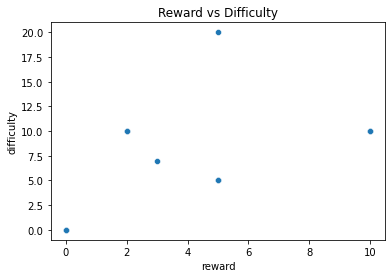

In [17]:
sns.scatterplot(x='reward', y='difficulty', data=df_portfolio)
plt.title('Reward vs Difficulty')
plt.show()

This shows the relationship between the reward and difficulty of the offers is not linear. There may be an increase in reward for the offers with higher difficulty until certain point but not for the maximum difficulty.

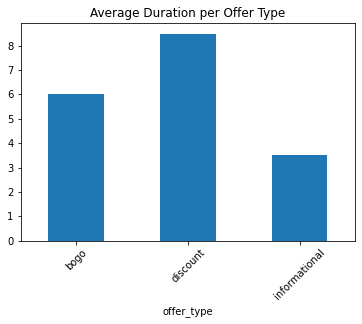

In [18]:
df_portfolio.groupby('offer_type').duration.mean().plot(kind='bar')
plt.title('Average Duration per Offer Type')
plt.xticks(rotation=45)
plt.show()

This shows the discounts are given a maximum duration on an average than any other offers.

## Cleaning data - Profile

In [19]:
#Checking for missing values
df_profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [20]:
#Let's look into the records having gender and income with null values
df_profile[df_profile.gender.isnull() & df_profile.income.isnull()]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [21]:
# Looks like the age is 118 for all null values
df_profile[df_profile.gender.isnull() & df_profile.income.isnull()]['age'].unique()

array([118])

In order to handle missing values, we may either fill them with suitable values or remove them. As the age is 118, we shall remove the records with null values

In [22]:
df_profile = df_profile.dropna()
df_profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [23]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [24]:
#The became_member_on column is a string, we need to convert it to datetime
df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'], format = '%Y%m%d')
df_profile.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [25]:
#Lets include a column that give the number of days the user has been a member. It will be useful for the analysis
from datetime import datetime
df_profile['membership_days'] = (datetime.today().date() - df_profile['became_member_on'].dt.date).dt.days
df_profile.head()

,gender,age,id,became_member_on,income,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1653
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1720
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1368
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1444
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1534


In [26]:
#Rename the id column to member_id
df_profile.rename(columns={'id':'member_id'}, inplace=True)

In [27]:
df_profile.head()

,gender,age,member_id,became_member_on,income,membership_days
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1653
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1720
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,1368
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,1444
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,1534


In [28]:
# get unique ids of users
member_id_list = np.array(list(set(profile.id.to_list())))

# cast nd array to dictionary
member_id_dict = dict(enumerate(member_id_list.flatten(), 1))

In [29]:
#member_id - converting to integers with proper tagging from original values
df_profile.member_id = df_profile.member_id.apply(lambda x: list(member_id_dict.values()).index(x))

## Exploratory Data Analysis - Profile

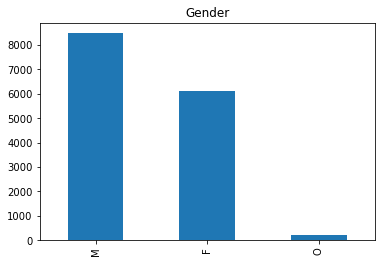

In [30]:
df_profile.gender.value_counts().plot(kind='bar')
plt.title('Gender')
plt.show()

This shows that men had responded more than women for the offers. Around 212 people had selected Others category.

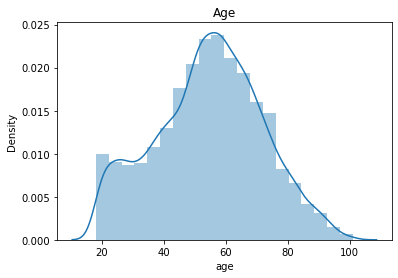

In [31]:
sns.distplot(df_profile.age, bins=20)
plt.title('Age')
plt.show()

This shows there is an approximate normal distribution in age and those with age group of 50-60 had responded more than any other age groups

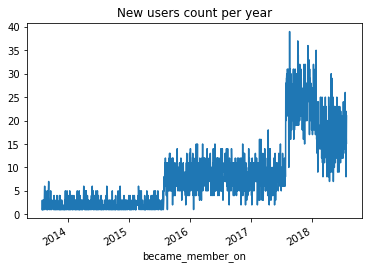

In [32]:
df_profile.groupby('became_member_on')['member_id'].count().plot()
plt.title('New users count per year')
plt.show()

This shows every couple of years, the new addition of membership doubled. There is a huge rise of membership between end of 2017 and the start of 2018 and then reduced again.

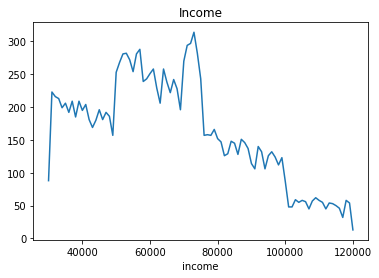

In [33]:
df_profile.groupby('income')['member_id'].count().plot()
plt.title('Income')
plt.show()

This shows the users with an average income of 65000 had responded more than any other income group.

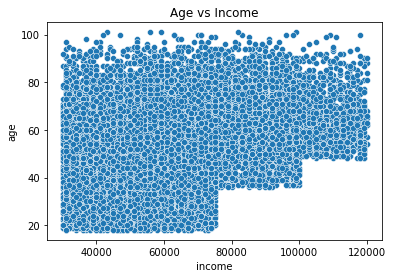

In [34]:
sns.scatterplot(x='income', y='age', data=df_profile)
plt.title('Age vs Income')
plt.show()

This shows there is no relationship between age and income.

In [35]:
df_profile.head()

,gender,age,member_id,became_member_on,income,membership_days
1,F,55,7577,2017-07-15,112000.0,1653
3,F,75,14394,2017-05-09,100000.0,1720
5,M,68,2901,2018-04-26,70000.0,1368
8,M,65,13084,2018-02-09,53000.0,1444
12,M,58,1480,2017-11-11,51000.0,1534


## Data Cleaning - Transcript

In [36]:
#Checking for missing values
df_transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [37]:
df_transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [38]:
#The value column contains a dictionary. We need to analyse the keys in the dictionary and separate them as columns
# values = df_transcript.value.explode().unique()
# values

In [39]:
#There are 'offer id' and 'offer_id' keys in the dictionary. Let us separate them as columns and then concatenate with the dataset to analyse
values_df = df_transcript.value.apply(pd.Series)
values_df.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [40]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  33579 non-null   object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


In [41]:
values_df.offer_id.isnull().sum()

272955

In [42]:
values_df.offer_id.unique()

array([nan, '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7'], dtype=object)

In [43]:
values_df.offer_id.fillna(0, inplace=True)
values_df['offer id'].fillna(0, inplace=True)


In [44]:
values_df.offer_id.isnull().sum()

0

In [45]:
values_df['offer_id_new'] = values_df['offer_id']

In [46]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   offer id      306534 non-null  object 
 1   amount        138953 non-null  float64
 2   offer_id      306534 non-null  object 
 3   reward        33579 non-null   float64
 4   offer_id_new  306534 non-null  object 
dtypes: float64(2), object(3)
memory usage: 11.7+ MB


In [47]:
values_df.head()

,offer id,amount,offer_id,reward,offer_id_new
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,NaN,0
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,NaN,0
2,2906b810c7d4411798c6938adc9daaa5,NaN,0,NaN,0
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,NaN,0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,NaN,0


In [48]:
values_df.isnull().sum()

offer id             0
amount          167581
offer_id             0
reward          272955
offer_id_new         0
dtype: int64

In [49]:
for i in values_df.index:
    if values_df['offer_id_new'][i] == 0:
        values_df['offer_id_new'][i] = values_df['offer id'][i]

In [50]:
#Since 'offer id' column and 'offer_id' column are same, we can merge them and remove the 'offer id' column.
values_df.drop(['offer id', 'offer_id'], axis=1, inplace=True)
values_df.rename({'offer_id_new':'offer_id'}, axis=1, inplace=True)

In [51]:
values_df.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '3f207df678b143eea3cee63160fa8bed',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '5a8bc65990b245e5a138643cd4eb9837', 0], dtype=object)

In [52]:
df_transcript = pd.concat([df_transcript, values_df], axis=1)
df_transcript_new = df_transcript.copy()
#Drop value column from the new dataset
df_transcript_new.drop(columns=['value'], inplace=True)

In [53]:
df_transcript_new.head()

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [54]:
#Renaming person to member_id column
df_transcript_new.rename(columns={'person':'member_id'}, inplace=True)
#member_id - converting to integers with proper tagging from original values
df_transcript_new.member_id = df_transcript_new.member_id.apply(lambda x: list(member_id_dict.values()).index(x))

In [55]:
df_transcript_new.head()

,member_id,event,time,amount,reward,offer_id
0,14394,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,13736,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,2901,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,7429,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,5600,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [56]:
df_transcript_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   member_id  306534 non-null  int64  
 1   event      306534 non-null  object 
 2   time       306534 non-null  int64  
 3   amount     138953 non-null  float64
 4   reward     33579 non-null   float64
 5   offer_id   306534 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.0+ MB


In [57]:
#Lets simplify the offer_id values as we did in df_portfolio dataset
df_transcript_new.offer_id = df_transcript_new.offer_id.map(offer_id_list)

In [58]:
df_transcript_new.offer_id.unique()

array([ 4.,  5., 10.,  7.,  2.,  9.,  6.,  3.,  1.,  8., nan])

In [59]:
df_transcript_new.head()

,member_id,event,time,amount,reward,offer_id
0,14394,offer received,0,NaN,NaN,4.0
1,13736,offer received,0,NaN,NaN,5.0
2,2901,offer received,0,NaN,NaN,10.0
3,7429,offer received,0,NaN,NaN,7.0
4,5600,offer received,0,NaN,NaN,2.0


## Exploratory Data Analysis - Transcript

To explore transcription data, let us analyse the data in terms of successful offers.

In [60]:
df_offers = df_transcript_new[df_transcript_new.event!='transaction']

In [61]:
df_offers.head()

,member_id,event,time,amount,reward,offer_id
0,14394,offer received,0,NaN,NaN,4.0
1,13736,offer received,0,NaN,NaN,5.0
2,2901,offer received,0,NaN,NaN,10.0
3,7429,offer received,0,NaN,NaN,7.0
4,5600,offer received,0,NaN,NaN,2.0


In [62]:
df_offers[df_offers.reward.isnull()].event.unique()

array(['offer received', 'offer viewed'], dtype=object)

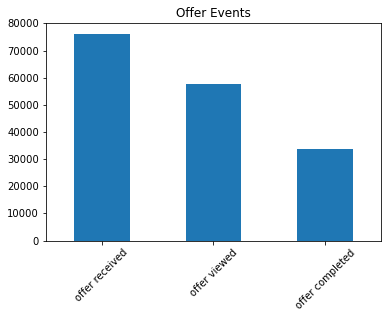

In [63]:
df_offers.event.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Offer Events')
plt.show()

This shows only 50% of the offers were successful.

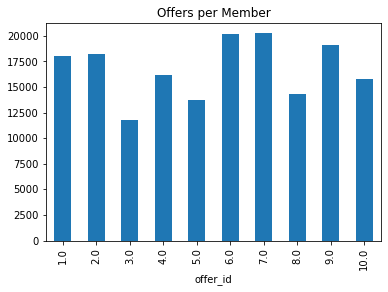

In [64]:
df_offers.groupby('offer_id')['member_id'].count().plot(kind='bar')
plt.title('Offers per Member')
plt.show()

This shows Offer number 6 (discount) and 7 (discount)  were sent to most of the users. Offer 3 (informational) least sent to the users.

In [65]:
df_offers.isnull().sum()

member_id         0
event             0
time              0
amount       167581
reward       134002
offer_id          0
dtype: int64

In [66]:
df_offers.event.unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [67]:
#Adding a separate column as offer_successful which will be set as target. The values will be 1 for 'offer completed' event else 0
df_offers['offer_successful'] = df_offers.event.apply(lambda x: 1 if x=='offer completed' else 0)
#Event column is now replace by offer_successful and the amount column is not required anymore.
df_offers.drop(columns=['event', 'amount'], inplace=True)
#Converting offer_id dtype to int
df_offers.offer_id = df_offers.offer_id.astype('int64') 

In [68]:
df_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   member_id         167581 non-null  int64  
 1   time              167581 non-null  int64  
 2   reward            33579 non-null   float64
 3   offer_id          167581 non-null  int64  
 4   offer_successful  167581 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 7.7 MB


## Merge Datasets

Lets merge the whole dataset with profile

In [69]:
profile_transcript1 = pd.merge(df_profile, df_transcript_new, on='member_id', how='left')

In [70]:
profile_transcript1.head()

,gender,age,member_id,became_member_on,income,membership_days,event,time,amount,reward,offer_id
0,F,55,7577,2017-07-15,112000.0,1653,transaction,18,21.51,NaN,NaN
1,F,55,7577,2017-07-15,112000.0,1653,transaction,144,32.28,NaN,NaN
2,F,55,7577,2017-07-15,112000.0,1653,offer received,408,NaN,NaN,4.0
3,F,55,7577,2017-07-15,112000.0,1653,offer received,504,NaN,NaN,3.0
4,F,55,7577,2017-07-15,112000.0,1653,transaction,528,23.22,NaN,NaN


In [71]:
#Lets check for duplicates
print("Total duplicates: ",profile_transcript1.duplicated().sum())
print("Shape of merged set: ",profile_transcript1.shape)
profile_transcript1.drop_duplicates(keep='first', inplace=True)
print("Total Duplicates after dropping: ",profile_transcript1.drop_duplicates().duplicated().sum())
print("Shape of merged set after dropping duplicates: ",profile_transcript1.shape)

Total duplicates:  374
Shape of merged set:  (272762, 11)
Total Duplicates after dropping:  0
Shape of merged set after dropping duplicates:  (272388, 11)


In [72]:
profile_transcript1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272388 entries, 0 to 272761
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gender            272388 non-null  object        
 1   age               272388 non-null  int64         
 2   member_id         272388 non-null  int64         
 3   became_member_on  272388 non-null  datetime64[ns]
 4   income            272388 non-null  float64       
 5   membership_days   272388 non-null  int64         
 6   event             272388 non-null  object        
 7   time              272388 non-null  int64         
 8   amount            123957 non-null  float64       
 9   reward            32070 non-null   float64       
 10  offer_id          148431 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(4), object(2)
memory usage: 24.9+ MB


In [73]:
#This dataset will be used later for pre-processing and validating the transaction data
profile_transcript1.to_csv('profile_transcript.csv', index=False)

In [125]:
#Uploading the cleaned data to input_data folder in the s3 default bucket
folder_name = "input_data"
test_data_path = 's3://{}/{}'.format(bucket, folder_name)
s3.upload_file('profile_transcript.csv', bucket, folder_name+'/profile_transcript.csv')

**Merging only offer dataset with profile**

In [74]:
profile_offers = pd.merge(df_profile,df_offers,on='member_id', how='left')
profile_offers.head()

,gender,age,member_id,became_member_on,income,membership_days,time,reward,offer_id,offer_successful
0,F,55,7577,2017-07-15,112000.0,1653,408.0,NaN,4.0,0.0
1,F,55,7577,2017-07-15,112000.0,1653,504.0,NaN,3.0,0.0
2,F,55,7577,2017-07-15,112000.0,1653,528.0,5.0,4.0,1.0
3,F,75,14394,2017-05-09,100000.0,1720,0.0,NaN,4.0,0.0
4,F,75,14394,2017-05-09,100000.0,1720,6.0,NaN,4.0,0.0


In [75]:
profile_offers.offer_successful.unique()

array([ 0.,  1., nan])

In [76]:
profile_offers.isnull().sum()

gender                   0
age                      0
member_id                0
became_member_on         0
income                   0
membership_days          0
time                     5
reward              116366
offer_id                 5
offer_successful         5
dtype: int64

In [77]:
rec_to_remove = profile_offers[profile_offers.offer_id.isnull()]
profile_offers = profile_offers.drop(rec_to_remove.index)
profile_offers.isnull().sum()

gender                   0
age                      0
member_id                0
became_member_on         0
income                   0
membership_days          0
time                     0
reward              116361
offer_id                 0
offer_successful         0
dtype: int64

In [78]:
#Filling null values in reward column to 0 as those records had event values of either 'offer received' or 'offer viewed'. As per the dataset, the reward will be given only if the event is 'offer completed'
profile_offers.reward.fillna(0, inplace=True)

In [79]:
profile_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148809
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   gender            148805 non-null  object        
 1   age               148805 non-null  int64         
 2   member_id         148805 non-null  int64         
 3   became_member_on  148805 non-null  datetime64[ns]
 4   income            148805 non-null  float64       
 5   membership_days   148805 non-null  int64         
 6   time              148805 non-null  float64       
 7   reward            148805 non-null  float64       
 8   offer_id          148805 non-null  float64       
 9   offer_successful  148805 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 12.5+ MB


In [80]:
#Converting offer_id, reward dtype to int
profile_offers.offer_id = profile_offers.offer_id.astype('int64')
profile_offers.reward = profile_offers.reward.astype('int64')

In [81]:
profile_offers.head()

,gender,age,member_id,became_member_on,income,membership_days,time,reward,offer_id,offer_successful
0,F,55,7577,2017-07-15,112000.0,1653,408.0,0,4,0.0
1,F,55,7577,2017-07-15,112000.0,1653,504.0,0,3,0.0
2,F,55,7577,2017-07-15,112000.0,1653,528.0,5,4,1.0
3,F,75,14394,2017-05-09,100000.0,1720,0.0,0,4,0.0
4,F,75,14394,2017-05-09,100000.0,1720,6.0,0,4,0.0


In [82]:
#Lets check for duplicates
print("Total duplicates: ",profile_offers.duplicated().sum())
print("Shape of merged set: ",profile_offers.shape)
profile_offers.drop_duplicates(keep='first', inplace=True)
print("Total Duplicates after dropping: ",profile_offers.drop_duplicates().duplicated().sum())
print("Shape of merged set after dropping duplicates: ",profile_offers.shape)

Total duplicates:  11129
Shape of merged set:  (148805, 10)
Total Duplicates after dropping:  0
Shape of merged set after dropping duplicates:  (137676, 10)


**Merging the profile-offer dataset with portfolio**

In [83]:
df = pd.merge(df_portfolio,profile_offers,on='offer_id', how='left')

In [84]:
df.shape

(137676, 18)

In [85]:
#Lets check for duplicates for the merge
print("Total duplicates: ",df.duplicated().sum())

Total duplicates:  0


In [86]:
df.head()

,reward_x,difficulty,duration,offer_type,offer_id,email,mobile,social,web,gender,age,member_id,became_member_on,income,membership_days,time,reward_y,offer_successful
0,10,10,7,bogo,1,1,1,1,0,F,75,14394,2017-05-09,100000.0,1720,408.0,0,0.0
1,10,10,7,bogo,1,1,1,1,0,F,75,14394,2017-05-09,100000.0,1720,510.0,10,1.0
2,10,10,7,bogo,1,1,1,1,0,F,61,7478,2017-09-11,57000.0,1595,408.0,0,0.0
3,10,10,7,bogo,1,1,1,1,0,F,61,7478,2017-09-11,57000.0,1595,426.0,10,1.0
4,10,10,7,bogo,1,1,1,1,0,F,61,7478,2017-09-11,57000.0,1595,432.0,0,0.0


In [87]:
#Drop reward_x - as it is a general reward info from portfolio dataset. reward_y is the reward info for the offer.
df.drop(['reward_x'], axis=1, inplace=True)
df.rename(columns={'reward_y':'reward'}, inplace=True)
#Converting offer_successful dtype to int
df.offer_successful = df.offer_successful.astype('int64')

In [88]:
df.head()

,difficulty,duration,offer_type,offer_id,email,mobile,social,web,gender,age,member_id,became_member_on,income,membership_days,time,reward,offer_successful
0,10,7,bogo,1,1,1,1,0,F,75,14394,2017-05-09,100000.0,1720,408.0,0,0
1,10,7,bogo,1,1,1,1,0,F,75,14394,2017-05-09,100000.0,1720,510.0,10,1
2,10,7,bogo,1,1,1,1,0,F,61,7478,2017-09-11,57000.0,1595,408.0,0,0
3,10,7,bogo,1,1,1,1,0,F,61,7478,2017-09-11,57000.0,1595,426.0,10,1
4,10,7,bogo,1,1,1,1,0,F,61,7478,2017-09-11,57000.0,1595,432.0,0,0


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137676 entries, 0 to 137675
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   difficulty        137676 non-null  int64         
 1   duration          137676 non-null  int64         
 2   offer_type        137676 non-null  object        
 3   offer_id          137676 non-null  int64         
 4   email             137676 non-null  int64         
 5   mobile            137676 non-null  int64         
 6   social            137676 non-null  int64         
 7   web               137676 non-null  int64         
 8   gender            137676 non-null  object        
 9   age               137676 non-null  int64         
 10  member_id         137676 non-null  int64         
 11  became_member_on  137676 non-null  datetime64[ns]
 12  income            137676 non-null  float64       
 13  membership_days   137676 non-null  int64         
 14  time

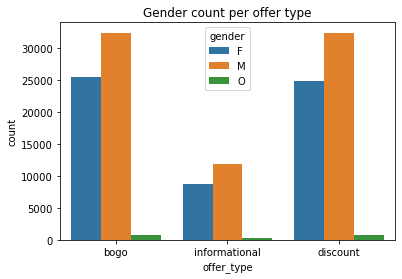

In [90]:
sns.countplot(x='offer_type',hue='gender',data=df)
plt.title('Gender count per offer type')
plt.show()

This shows both BOGO and discount offers were equally sent to women. As previously analysed, men were the majority receivers / responders of the offers.

### Feature Engineering

All datasets are merged successfully based on member_id and offer_id. Now, the nerged dataset needs to be cleaned and feature engineered to be model ready.

In [91]:
# 1. email - removing this from the feature list as email is used for all the offers
df.drop(['email'], axis=1, inplace=True)
#5. became_member_on - removing this datetime feature as it doesnt have more impacts
df.drop(['became_member_on'], axis=1, inplace=True)

In [92]:
# 2. offer_type - nominal encoding (0 - BOGO, 1 - Discount, 2 - Informational)
offer_types = {'bogo':0, 'discount':1, 'informational':2}
df.offer_type = df.offer_type.map(offer_types)

In [93]:
#3. gender - nominal encoding (0 - Male, 1 - Female, 2 - Others)
gender_list = {'M': 0, 'F':1, 'O':2}
df.gender = df.gender.map(gender_list)

In [94]:
#6. time - converting to integer values
df.time = df.time.astype('int64')

In [95]:
#The csv file will be used for training the model in sagemaker
df.to_csv('cleaned_data.csv', index=False)

In [99]:
#Uploading the cleaned data to test_data folder in the s3 default bucket
folder_name = "cleaned_data"
s3 = boto3.client('s3')
s3.put_object(Bucket=bucket, Key=folder_name+'/')
test_data_path = 's3://{}/{}'.format(bucket, folder_name)
s3.upload_file('cleaned_data.csv', bucket, folder_name+'/cleaned_data.csv')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137676 entries, 0 to 137675
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   difficulty        137676 non-null  int64  
 1   duration          137676 non-null  int64  
 2   offer_type        137676 non-null  int64  
 3   offer_id          137676 non-null  int64  
 4   mobile            137676 non-null  int64  
 5   social            137676 non-null  int64  
 6   web               137676 non-null  int64  
 7   gender            137676 non-null  int64  
 8   age               137676 non-null  int64  
 9   member_id         137676 non-null  int64  
 10  income            137676 non-null  float64
 11  membership_days   137676 non-null  int64  
 12  time              137676 non-null  int64  
 13  reward            137676 non-null  int64  
 14  offer_successful  137676 non-null  int64  
dtypes: float64(1), int64(14)
memory usage: 21.8 MB


## Building a model

Let us try to build a model to predict the success of the offers. As our goal is to predict if the offer is successful or nt, we choose to build various models using binary classification algorithms. We will use the following algorithms and will choose the best one. It is then deployed in the sagemaker server and the endpoint will be tested in lambda.
* Logistic Regression
* K-Nearest Neighbors
* Support Vector Machine
* Naive Bayes
* Decision Tree
* Random Forest

In [101]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X = df.drop(['offer_successful'], axis=1)
y = df['offer_successful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
#Scaling the data for some algorithms
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)

In [103]:
#Metrics imports
from sklearn.metrics import accuracy_score, confusion_matrix

In [104]:
train_score = {}
test_score = {}

**Logistic Regression**

In [105]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

In [106]:
train_score['LR'] = accuracy_score(y_train, lr.predict(X_train_scaled))
test_score['LR'] = accuracy_score(y_test, lr_pred)
print("Logistic Regression train accuracy score: ", train_score['LR'])
print("Logistic Regression test accuracy score: ",test_score['LR'])
print("Confusion matrix: \n", confusion_matrix(y_test, lr_pred))

Logistic Regression train accuracy score:  1.0
Logistic Regression test accuracy score:  1.0
Confusion matrix: 
 [[21066     0]
 [    0  6470]]


**K-Nearest Neighbors**

In [107]:
from sklearn.neighbors import KNeighborsClassifier

In [108]:
knn_list = []
def get_knn_score(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    knn_pred = knn.predict(X_test_scaled)
    knn_list.append(accuracy_score(y_test, knn_pred))
    return knn_list

In [109]:
for i in range(1, 11):
    get_knn_score(i)

In [110]:
knn_list

[0.9944436374201046,
 0.9904851830331203,
 0.9947704822777454,
 0.9912115049389889,
 0.9959325973271353,
 0.993136257989541,
 0.9960052295177223,
 0.9934267867518884,
 0.9954968041836142,
 0.9932088901801278]

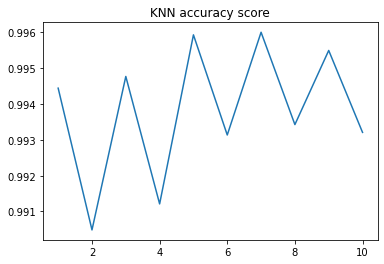

In [111]:
plt.plot(range(1, 11), knn_list)
plt.title('KNN accuracy score')
plt.show()

Choosing n_neighbors=5 as it has the best accuracy score

In [112]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [113]:
train_score['KNN'] = accuracy_score(y_train, knn.predict(X_train_scaled))
test_score['KNN'] = accuracy_score(y_test, knn.predict(X_test_scaled))
print("K-Nearest Neighbors train accuracy score: ", train_score['KNN'])
print("K-Nearest Neighbors test accuracy score: ",test_score['KNN'])
print("Confusion matrix: \n", confusion_matrix(y_test, knn.predict(X_test_scaled)))

K-Nearest Neighbors train accuracy score:  0.9980660976938442
K-Nearest Neighbors test accuracy score:  0.9959325973271353
Confusion matrix: 
 [[21066     0]
 [  112  6358]]


**Support Vector Machine**

In [114]:
from sklearn.svm import SVC
svc_clf = SVC(kernel='linear')
svc_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [115]:
train_score['SVM'] = accuracy_score(y_train, svc_clf.predict(X_train_scaled))
test_score['SVM'] = accuracy_score(y_test, svc_clf.predict(X_test_scaled))
print("Support Vector Machine train accuracy score: ", train_score['SVM'])
print("Support Vector Machine test accuracy score: ",test_score['SVM'])
print("Confusion matrix: \n", confusion_matrix(y_test, svc_clf.predict(X_test_scaled)))

Support Vector Machine train accuracy score:  1.0
Support Vector Machine test accuracy score:  1.0
Confusion matrix: 
 [[21066     0]
 [    0  6470]]


**Naive Bayes**

In [116]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [117]:
train_score['NB'] = accuracy_score(y_train, nb.predict(X_train))
test_score['NB'] = accuracy_score(y_test, nb.predict(X_test))
print("Naive Bayes train accuracy score: ", train_score['NB'])
print("Naive Bayes test accuracy score: ",test_score['NB'])
print("Confusion matrix: \n", confusion_matrix(y_test, nb.predict(X_test)))

Naive Bayes train accuracy score:  1.0
Naive Bayes test accuracy score:  1.0
Confusion matrix: 
 [[21066     0]
 [    0  6470]]


**Decision Tree**

In [118]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [119]:
train_score['DT'] = accuracy_score(y_train, dt.predict(X_train))
test_score['DT'] = accuracy_score(y_test, dt.predict(X_test))
print("Decision Tree Classifier train accuracy score: ", train_score['DT'])
print("Decision Tree Classifier test accuracy score: ",test_score['DT'])
print("Confusion matrix: \n", confusion_matrix(y_test, dt.predict(X_test)))

Decision Tree Classifier train accuracy score:  1.0
Decision Tree Classifier test accuracy score:  1.0
Confusion matrix: 
 [[21066     0]
 [    0  6470]]


**Random Forest**

In [120]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [121]:
train_score['RF'] = accuracy_score(y_train, rf.predict(X_train))
test_score['RF'] = accuracy_score(y_test, rf.predict(X_test))
print("Random Forest train accuracy score: ", train_score['RF'])
print("Random Forest test accuracy score: ",test_score['RF'])
print("Confusion matrix: \n", confusion_matrix(y_test, rf.predict(X_test)))

Random Forest train accuracy score:  1.0
Random Forest test accuracy score:  1.0
Confusion matrix: 
 [[21066     0]
 [    0  6470]]


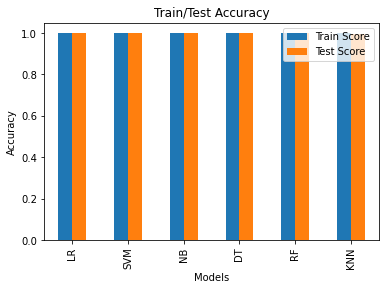

In [122]:
df_score = pd.DataFrame({'Models':train_score.keys(),'Train Score':train_score.values(),'Test Score':test_score.values()})
df_score.sort_values('Train Score',ascending=False).\
plot(kind='bar',x='Models',y=['Train Score','Test Score'],title='Train/Test Accuracy',ylabel='Accuracy')
plt.show()


Almost all the models have the same accuracy score. However, we need to train, test and deploy a suitable model. Then the endpoint needs to be checked in lambda function.
The notebook train_and_deploy.ipynb is expected to run in sagemaer notebook instance for final evaluation